# Charon4 txt to Python
This script loads the data exported with charon4. The following screenshot shows the expected settings while exporting.

<img src=".\pictures\Charon4_export_window_txt.png" alt="drawing" width="500"/>



In [1]:
version="v1_0"
# Changelog
#
#

import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt


# To-Do
# Data Daniel und diese Daten mergen. erstmal vergleichen ob sie gleich sind. Der Part der sich überscheidet 
# Im Plot am Ende genaues Datum markieren, ab dem es kaum Daten gibt

In [2]:
# Input
#path to working directory
#mit \[-]\ im Pfad funktioniert die get_abspath Funktion nicht
path_to_controller=r"..\Alsdorf\Daten\export\charon4_export_as_txt"

In [3]:
#############Input###################################
channels=[1,2,3,4,5,6,7]
years=[2019,2020,2021] #2018 teilweise anders format? seperat angucken
months=[1,2,3,4,5,6,7,8,9,10,11,12]
################################################

controller=3188 # 3188: Alsdorf

# generate all requested paths, some paths may be empty
paths_for_activate={}
for year in years:
    for channel in channels:
        for month in months:
            paths_for_activate[f"temp_ch{channel}_year{year}_month{month}"] = path_to_controller + f"\Controller\{controller}\{channel}\Temperature Data\{year}\{month}"

#paths_for_activate

In [4]:
def get_abspath(basepath):
    """Get the files you need to import into your script with Path
    Returns a list of all filepaths (or folderpaths) of the files (or folders) in a repository.
    The repository is given this function with basepath.
    """
    df_list = []
    basepath = glob.glob(basepath)
    for entry in basepath:
        df_list.append(entry)
    return (df_list)

def import_temp_to_df(path):
    """"""
    df = pd.read_csv(path,skiprows=7,decimal=".",delimiter="\t",index_col=0)
    df = df.drop(df.columns[0:2],axis=1)
    df.index.names = ['Date']
    df.index = pd.to_datetime(df.index, infer_datetime_format=True)
    return df

In [5]:
%%time

# dic erstellen mit 0 und 1 für jeden Monat pro Jahr und rein schreiben, ob dort Daten sind

# maybe its best to store not everything in one variable
from collections import defaultdict
# see here why defaultdict is used:
# https://stackoverflow.com/questions/44992106/how-do-i-create-a-nested-dictionary-under-a-key-that-is-yet-to-exist
data_2018=defaultdict(dict)
data_2019=defaultdict(dict)
data_2020=defaultdict(dict)
data_2021=defaultdict(dict)

# Create dict to count for which month data is avaible
#df=pd.DataFrame(index=months,columns=years)
#df.index.names = ['Month']
data_for_month_avaible={} #keys are channels
for channel in channels:
    data_for_month_avaible[channel] = pd.DataFrame(index=months,columns=years)
    data_for_month_avaible[channel].index.names = ['Month']

for name in paths_for_activate.keys(): # loop for every channel of every month
    my_path=paths_for_activate[name] + "\*"
    my_path_to_file=get_abspath(my_path)

    # get info about data from name
    partition1=name.partition("_year")[-1].partition("_month")
    year=partition1[0]
    month=partition1[-1]
    channelnumber=name.partition("_year")[0].partition("temp_ch")[-1]

    # check if the month folder contains more than one file 
    if len(my_path_to_file) > 1:
        data_for_month_avaible[int(channelnumber)][int(year)][int(month)]=1
        if name != "temp_ch2_year2019_month7":
            print("one months contains more than one file, script should be checked! Only encountered this ones")
            print(name)
        # adaption of script
        # Import Data, one option
        one_file=import_temp_to_df(my_path_to_file[0])
        for i in range(1,len(my_path_to_file)):
            additional_files=import_temp_to_df(my_path_to_file[i])
            #display(additional_files)
            #display(one_file)
            one_file=pd.concat([one_file,additional_files],axis=0)
            #display(one_file)
        
        ## Store Data in dic - best would be putting this in a user-defined-function
        # or creating an if with >=1
        if year == "2018":
            data_2018[channelnumber][month] = one_file
        
        if year == "2019":
            data_2019[channelnumber][month] = one_file

        if year == "2020":
            data_2020[channelnumber][month] = one_file

        if year == "2021":
            data_2021[channelnumber][month] = one_file
    
    if len(my_path_to_file) == 0: # wenn pfad zu keinem file führt dann wird leere Liste returned
        data_for_month_avaible[int(channelnumber)][int(year)][int(month)]=0
    
    if len(my_path_to_file) == 1:
        data_for_month_avaible[int(channelnumber)][int(year)][int(month)]=1
        
        # Import Data, second optio 
        one_file=import_temp_to_df(my_path_to_file[0])

        ## Store Data in dic
        if year == "2018":
            data_2018[channelnumber][month] = one_file
        
        if year == "2019":
            data_2019[channelnumber][month] = one_file

        if year == "2020":
            data_2020[channelnumber][month] = one_file

        if year == "2021":
            data_2021[channelnumber][month] = one_file

Wall time: 1min 41s


In [6]:
%%time

def save_data(data_20xx,save_to_path):
    """"""
    for channel in data_20xx.keys():
        first_month=list(data_20xx[channel].keys())[0]
        one_file=data_20xx[channel][first_month]
        for month in list(data_20xx[channel].keys())[1:]: #skip first month, defined above
            one_file=pd.concat([one_file, data_20xx[channel][month]], axis=0)
        
        # save data
        year=one_file.index[10].strftime("%Y") #randomly chose 10; very bad solution
        filename=f"\\temp_ch{channel}_{year}.csv"
        one_file.to_csv(save_to_path + filename, )

# Save data
save_to = path_to_controller + "\..\..\Charon4\easy_access_with_python"

save_data(data_2021,save_to)
save_data(data_2020,save_to)
save_data(data_2019,save_to)

Wall time: 8min 43s


In [7]:
#Load data - example
# temp_ch1_2021.csv temp_ch2_2021.csv temp_ch3_2021.csv temp_ch4_2021.csv
# temp_ch1_2020.csv temp_ch2_2020.csv temp_ch3_2020.csv temp_ch4_2020.csv
# temp_ch1_2019.csv temp_ch2_2019.csv temp_ch3_2019.csv temp_ch4_2019.csv
#filename=f"\\temp_ch2_2020.csv" 
#test=pd.read_csv(save_to + filename, index_col=0)
#test

,0.00,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,...,798.00,799.00,800.00,801.00,802.00,803.00,804.00,805.00,806.00,807.00
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-29 09:51:50,22.92,23.15,23.47,23.60,23.36,22.96,22.51,21.96,20.88,19.30,...,24.37,24.26,24.09,24.01,23.92,23.69,23.54,23.64,23.80,23.82
2020-03-18 10:35:00,23.81,24.27,24.53,24.55,24.34,24.03,23.54,22.89,21.73,20.25,...,23.95,23.82,23.86,24.00,23.99,23.72,23.48,23.51,23.54,23.45
2020-03-18 10:52:08,23.78,24.23,24.41,24.38,24.20,23.93,23.45,22.80,21.71,20.27,...,24.04,23.82,23.71,23.80,23.78,23.58,23.51,23.53,23.40,23.31
2020-03-18 11:17:02,23.73,24.19,24.41,24.29,24.11,23.89,23.40,22.79,21.74,20.30,...,24.04,23.80,23.61,23.50,23.44,23.39,23.42,23.46,23.35,23.23
2020-03-18 11:33:02,23.82,24.11,24.31,24.31,24.18,23.99,23.59,23.07,22.08,20.65,...,24.19,23.91,23.83,23.77,23.64,23.55,23.61,23.67,23.55,23.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 22:55:21,25.22,25.27,25.41,25.35,25.12,24.81,24.24,23.42,22.18,20.77,...,23.97,23.79,23.76,23.78,23.70,23.47,23.46,23.72,23.89,23.83
2020-12-31 23:11:21,25.28,25.39,25.56,25.53,25.27,24.85,24.27,23.49,22.20,20.72,...,24.08,23.93,23.86,23.84,23.72,23.49,23.50,23.76,23.93,23.88
2020-12-31 23:27:22,25.16,25.32,25.51,25.44,25.11,24.65,24.17,23.44,22.14,20.74,...,23.82,23.57,23.54,23.59,23.50,23.27,23.36,23.64,23.62,23.49


In [8]:
from collections import Counter
#def measurements_per_day(df):
#    """index of the dataframe has to be datetime
#    """
#    dates = df.index.get_level_values('Date').floor('D')
#    number_unique_days=len(dates.unique())
#    return number_unique_day
    

def calculate_measurements_per_day(dic,print_output=True):
    """dic has to be the nested data dictionary
    returns dataframe with number pf unique days, depending on channelnumber and month
    """
    #create dataframe to save the number of unique days per month.
    #this means the number of days per month with at least one measurement
    df_unique_days_month=pd.DataFrame(index=months,columns=channels)
    df_unique_days_month.index.names = ['Month']


    n_meas_pday=defaultdict(dict) # save number of measurements per day, depending on channel
    channelnumbers=dic.keys()
    for c in channelnumbers: # loop over each channel
        months_values=dic[c].keys()
        for m in months_values: # loop over each month
            one_file=dic[c][m]

            dates = one_file.index.get_level_values('Date').floor('D') # drop time of day information
            number_unique_day = len(dates.unique())
            #print(f"In month {m} of channel {c} are {number_unique_day} days with measurements")
            df_unique_days_month[int(c)][int(m)]=number_unique_day 
            
            count_measurements=Counter(dates) #Counts the occurence of the same date
            min_meas_day = 10 # threshhold of allowed measurements per day which is ok.
            for day in dates.unique():
                n_meas_pday[c][day.strftime("%Y-%m-%d")]=count_measurements[day]
                #if c == 1:
                #    test_1[day]=count_measurements[day]

                # print if day has less than 10 measurements
                if count_measurements[day] <= min_meas_day and print_output == True: 
                    print(f"{day.date()} has less than 10 measurements per day in channel {c}")


    return df_unique_days_month, n_meas_pday

In [9]:
%%time
#count the number of measurements per day; at the moment missing days are not printed

print("data 2019")
df_unique_days_month_2019, n_meas_pday_2019 = calculate_measurements_per_day(data_2019)

print();print();print("data 2020")
df_unique_days_month_2020, n_meas_pday_2020 = calculate_measurements_per_day(data_2020)

print();print();print("data 2021")
df_unique_days_month_2021, n_meas_pday_2021 = calculate_measurements_per_day(data_2021)

data 2019
2019-10-18 has less than 10 measurements per day in channel 2
2019-10-18 has less than 10 measurements per day in channel 3
2019-10-18 has less than 10 measurements per day in channel 4


data 2020
2020-01-29 has less than 10 measurements per day in channel 1
2020-01-29 has less than 10 measurements per day in channel 2
2020-01-29 has less than 10 measurements per day in channel 3
2020-01-29 has less than 10 measurements per day in channel 4


data 2021
Wall time: 763 ms


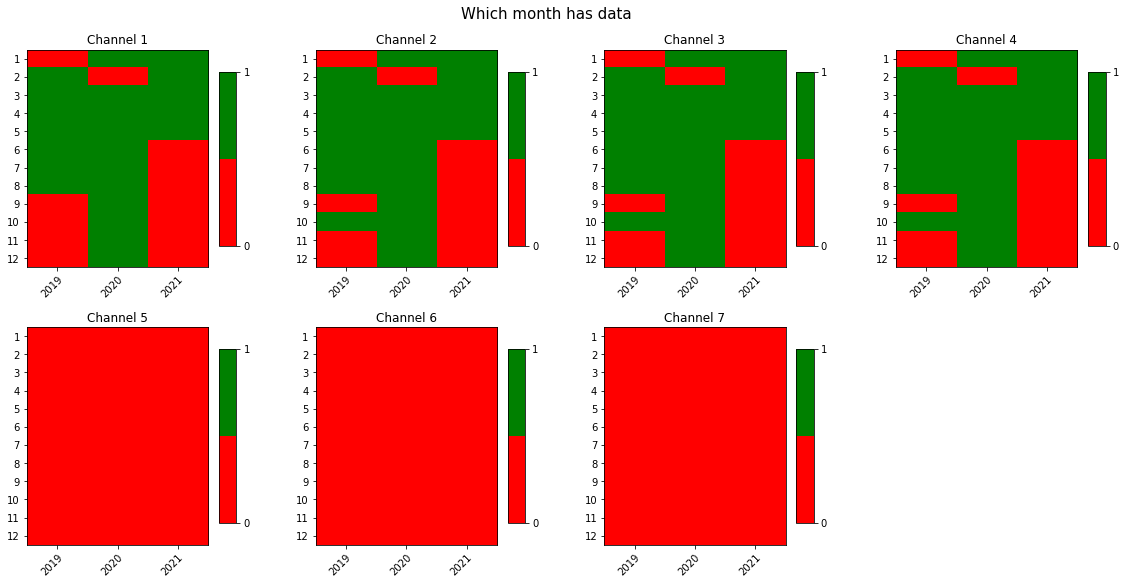

In [10]:
########################################to do ##############################################
# add df_unique_days_month_2019 numbers to plot
# besser anderen Graphen, x-Achse Zeit; y-Achse Messungen prt Tag


# Avaible Data Overview
# 1: there was a file
# 0: there was no file
from matplotlib import colors

fig, axes = plt.subplots(2,4,figsize=[16,8],constrained_layout=True)
fig.suptitle("Which month has data", fontsize=15)
cmap = colors.ListedColormap(['red', 'green'])
#norm = colors.Normalize(vmin=0, vmax=1)
channel_plot=0
for ax in axes.flat[0:-1]:
    channel_plot+=1
    im = ax.imshow(data_for_month_avaible[channel_plot].to_numpy(dtype=int), cmap=cmap, aspect=0.3,vmin=0,vmax=1)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(["2019","2020","2021"])
    ax.set_yticks([0,1,2,3,4,5,6,7,8,9,10,11])
    ax.set_yticklabels([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_title(f"Channel {channel_plot}")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    cbar = ax.figure.colorbar(im,ax=ax,shrink=0.8,ticks=[0,1])

axes[1, 3].remove()  # don't display empty ax
#fig.tight_layout()
plt.show()

In [11]:
#from calendar import monthrange

#monthrange(2019,12) #Returns weekday of first day of the month and number of days in month, for the specified year and month.

In [12]:
from datetime import date, timedelta
def all_days_of_year(year, day_format="%Y-%m-%d"):
    """returns list with all days of a year in day_format (used in .strftime)"""
    output=[]
    #A timedelta object of 1 day
    oneday = timedelta(days=1)

    #A date object of the start of the year
    current_day = date(year, 1, 1)

    #Print all the days of the given year in YYYYmmdd format
    while current_day.year == year:
        output.append(current_day.strftime(day_format))
        current_day += oneday
    return output

In [13]:
# Improve n_meas_pdy: add days where 0 measurements were made
# days with 0 measurements will occur in these dictionaries

def improve_n_meas_pday(n_meas_pday, year):
    """returns a dic, which also has days with 0 measurements"""
    improved_n_meas_pday=defaultdict(dict)
    channelnumbers=["1","2","3","4","5","6","7"]
    for c in channelnumbers: # loop over each channel
        for day in all_days_of_year(year):
            if day in n_meas_pday[c].keys():
                improved_n_meas_pday[c][day] = n_meas_pday[c][day]
            else:
                improved_n_meas_pday[c][day] = 0
    return improved_n_meas_pday

n_meas_pday_2019_with0=improve_n_meas_pday(n_meas_pday_2019, 2019)
n_meas_pday_2020_with0=improve_n_meas_pday(n_meas_pday_2020, 2020)
n_meas_pday_2021_with0=improve_n_meas_pday(n_meas_pday_2021, 2021)

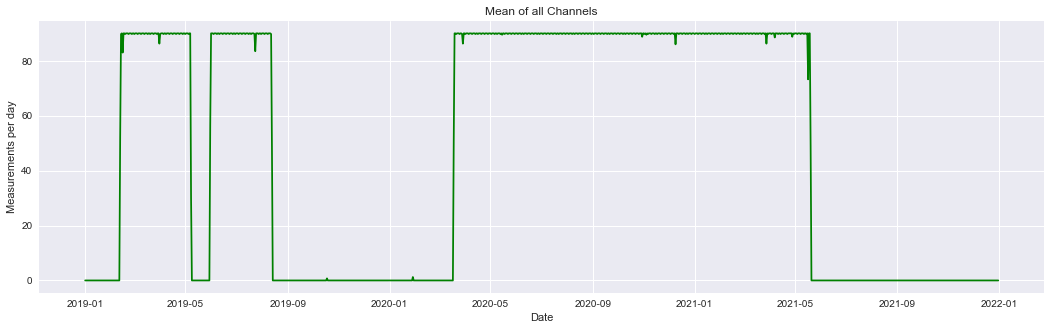

In [17]:
#Plot means measurements per channel
def calc_mean_channels_n_pday(n_meas_pday_20xx_with0):
    """calculate the number of measurements as mean over the 4 channels"""
    val_ch1=np.array(list(n_meas_pday_20xx_with0["1"].values()))
    val_ch2=np.array(list(n_meas_pday_20xx_with0["2"].values()))
    val_ch3=np.array(list(n_meas_pday_20xx_with0["3"].values()))
    val_ch4=np.array(list(n_meas_pday_20xx_with0["4"].values()))
    mean=(val_ch1+val_ch2+val_ch3+val_ch4)/4

    # check if dates are equal
    date_ch1=pd.to_datetime(list(n_meas_pday_20xx_with0["1"]))
    date_ch2=pd.to_datetime(list(n_meas_pday_20xx_with0["2"]))
    date_ch3=pd.to_datetime(list(n_meas_pday_20xx_with0["3"]))
    date_ch4=pd.to_datetime(list(n_meas_pday_20xx_with0["4"]))
    counter_equal=0
    counter_not_equal=0
    for i in range(len(date_ch1)):
        if date_ch1[i] == date_ch2[i] and date_ch3[i] and date_ch4[i]:
            #print("all dates for mean calculation are equal")
            counter_equal+=1
    else:
        #print("dates for mean calculation are not equal!")
        #print(date_ch1[i]);print(date_ch2[i]);print(date_ch3[i]);print(date_ch4[i])
        counter_not_equal+=1
    if counter_not_equal >= 3: # 31.12. seems to be a problem? Dont know why. Not very important.
        print("check dates")
    return mean, date_ch1

mean_2019, date_2019 = calc_mean_channels_n_pday(n_meas_pday_2019_with0)
mean_2020, date_2020 = calc_mean_channels_n_pday(n_meas_pday_2020_with0)
mean_2021, date_2021 = calc_mean_channels_n_pday(n_meas_pday_2021_with0)

plt.style.use("seaborn")
plt.figure(figsize=[18,5])
plt.plot(date_2019, mean_2019,color="green")
plt.plot(date_2020, mean_2020,color="green")
plt.plot(date_2021, mean_2021,color="green")
plt.ylabel("Measurements per day")
plt.xlabel("Date")
plt.title(f"Mean of all Channels")
plt.savefig("pictures/mean_of_all_channels.png")
plt.savefig("pictures/mean_of_all_channels_dpi720.png", dpi=720)
plt.show()

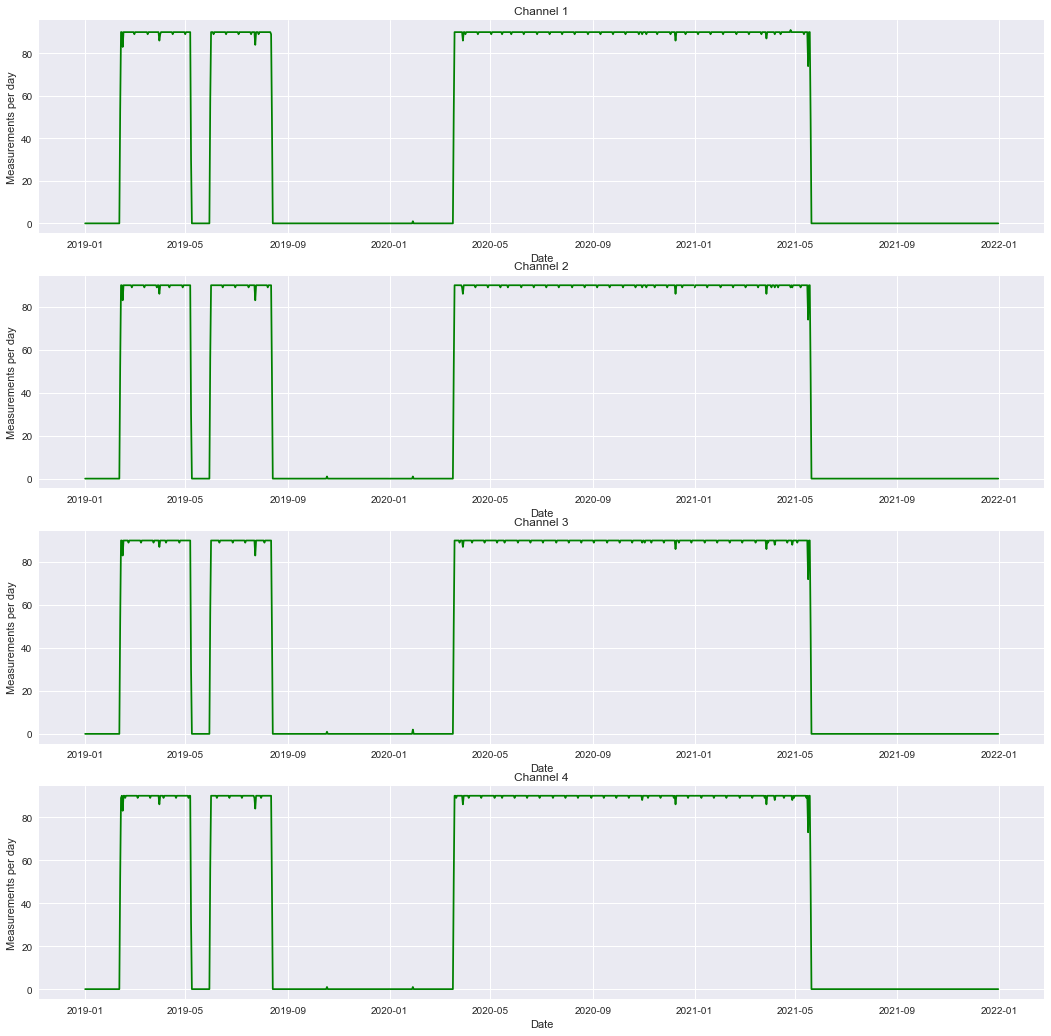

In [15]:
# Plot each channel seperate
#from cycler import cycler

plt.style.use("seaborn")
# when plotting all different channels in one plot using a loop, this cycler is handy
#plt.rc('lines', linewidth=4)
#plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y']) + cycler('linestyle', ['--', '--', '--', '--'])))
fig,axs=plt.subplots(4,1,figsize=[18,18])
for channel in ["1","2","3","4"]:
    n=int(channel)-1
    c="green"
    axs[n].plot(pd.to_datetime(list(n_meas_pday_2019_with0[channel])), n_meas_pday_2019_with0[channel].values(),color=c)
    axs[n].plot(pd.to_datetime(list(n_meas_pday_2020_with0[channel])), n_meas_pday_2020_with0[channel].values(),color=c)
    axs[n].plot(pd.to_datetime(list(n_meas_pday_2021_with0[channel])), n_meas_pday_2021_with0[channel].values(),color=c)
    axs[n].set_ylabel("Measurements per day")
    axs[n].set_xlabel("Date")
    axs[n].set_title(f"Channel {channel}")
#axs.set_prop_cycle(cycler('color', ['c', 'm', 'y', 'k']) + cycler('lw', [1, 2, 3, 4]))



# part which was overwritten, 2019-09 till 2020-01, in sciebo are data till 2019-10.

# 90 Messungen pr Tag pro Channel is maximum: 24*60*60/90/4 = 240 s Mittelungszeitraum einer Messung
# 24*60*60: Sekunden pro Tag
# 90: Messungen pro Tag
# 4: Channel in denen gemessen wird